# Global Position Variance Estimation

This notebook investigates how the `eph` (horizontal error standard deviation in meters) and `epv` (vertical error standard deviation in meters) values of the global position generated by GISNav depend on flight altitude in a SITL simulation. 

The lower bound of the ideal flight altitude is restricted by the reference map ground sample distance (GSD), since the camera field of view will not contain any interesting features useful for matching if flying too low compared to the map resolution. The upper bound of the ideal flight altitude is restricted by the spatial resolution of the (simulated) camera, as features relevant for matching become too small compared to camera resolution when flying too high.

## Imports, paths & other configuration

ULog flight logs are assumed to be found under `./output`.

We use `pyulog` to parse the ULog file (`pip install pyulog`, or `pip install .[dev]` in the GISNav ROS 2 package root folder where the `setup.py` file is located).

In [93]:
import os
import pyulog

print(f'pyulog version: {pyulog.__version__}')

ulog_relative_path = './output'
ulog_absolute_path = os.path.abspath(os.path.join(os.getcwd(), ulog_relative_path))

print(f'ULog file path is set to {ulog_absolute_path}')

pyulog version: 1.0.1
ULog file path is set to /home/hmakelin/colcon_ws/src/gisnav/gisnav/test/sitl/ulog_analysis/output


## Read ULog files

We analyze the first ULog file in the list of detected files. Change the `index` variable value to analyze a different file.

The `log_7_2024-3-9-09-52-38.ulg` log file should have the following simulation context:
* GISNav version `v0.65.0-123-gef8f326`
* USGS NAIP orthoimagery: 1-meter ground sampling distance (GSD)
* Camera resolution: 640x360
* LoFTR model
* Vehicle and camera facing east at starting location (lat, lon) with camera 5 degrees off nadir throughout the whole simulation (only altitude changes)

In [234]:
logs = []

for file in os.listdir(ulog_path):
    if file.endswith(".ulog") or file.endswith(".ulg"):
        logs.append(file)

print(f'Found following log files:\n{logs}')

index = 0
log_filename = logs[0]
print(f'Analyzing log with index 0: {log_filename}')

ulog = pyulog.ULog(os.path.join(ulog_path, log_filename))

Found following log files:
['log_7_2024-3-9-09-52-38.ulg']
Analyzing log with index 0: log_7_2024-3-9-09-52-38.ulg


## Extract global position ground truth and estimates

Here we extract the estimated and ground truth 3D global position into numpy arrays. GISNav generated observations are selected via the `satellites_used` value which should be `255`. The timestamps will not match.

In [235]:
data: dict = ulog.get_dataset("vehicle_gps_position").data
data_global_gt: dict = ulog.get_dataset("vehicle_global_position_groundtruth").data

# For estimates, the scaling is 1e7 for lat and lon, and 1e3 for altitude
gps_position_estimates = np.array(
    [
        (data["timestamp"][i], data["lon"][i]/1e7, data["lat"][i]/1e7, data["alt"][i]/1e3)
        for i, value in enumerate(data["satellites_used"]) 
        if value == 255
    ]
)

# No scaling for ground truth
gps_position_gt = np.array(
    list(
        zip(
            data_global_gt["timestamp"], data_global_gt["lon"], data_global_gt["lat"], data_global_gt["alt"]
        )
    )
)

print("The 4 columns are timestamp, latitude, longitude, and altitude in meters:")
print(f"Ground truth array shape: {gps_position_gt.shape}")
print(f"Estimate array shape: {gps_position_estimates.shape}")

The 4 columns are timestamp, latitude, longitude, and altitude in meters:
Ground truth array shape: (13819, 4)
Estimate array shape: (1030, 4)


# Convert lat and lon to meters relative to reference location

We need to convert the WGS 84 latitude and longitude to meters since we are interested in the `eph` and `epv` values which are defined in meters. We use the Haversine formula and use the average of the coordinates as the reference position.

In [236]:
def haversine(lon1, lat1, lon2, lat2, sign_flag):
    # Radius of the Earth in meters
    R = 6371000
    # Convert coordinates from degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    
    # Difference in coordinates
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    
    # Haversine formula
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arctan2(sqrt(a), sqrt(1-a))
    distance = R * c

    # Flag to tell whether this is distance in northing or easting direction - a bit hacky
    sign = np.sign(dlat) if sign_flag else np.sign(dlon)
    
    return sign * distance

def convert_to_meters(coords, reference_point):
    avg_lat, avg_lon = reference_point

    # Convert each coordinate to meters relative to the average location
    meters = np.array([(haversine(avg_lon, avg_lat, lon, avg_lat, False), haversine(avg_lon, avg_lat, avg_lon, lat, True)) for lat, lon in coords])
    return meters

def compute_reference_point(coords):
    # Calculate the average latitude and longitude
    avg_lat = sum(lat for lat, lon in coords) / len(coords)
    avg_lon = sum(lon for lat, lon in coords) / len(coords)
    return avg_lat, avg_lon

# Arbitrary reference point that we use to convert the lat and lon to meters, must be same for ground truth and estimates
reference_point = compute_reference_point(gps_position_gt[:, 1:3])

xy_estimates = convert_to_meters(gps_position_estimates[:, 1:3], reference_point)
xy_gt = convert_to_meters(gps_position_gt[:, 1:3], reference_point)

# xy_gt ground truth values should be very close to zero as the drone is supposed to hold position in the simulator,
# xy_estimates values should be larger

print(xy_estimates.shape)
print(xy_gt.shape)

(1030, 2)
(13819, 2)


/tmp/ipykernel_200620/3008199082.py:30: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  avg_lat = sum(lat for lat, lon in coords) / len(coords)
/tmp/ipykernel_200620/3008199082.py:31: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  avg_lon = sum(lon for lat, lon in coords) / len(coords)


# Match timestamps

We pick timestamps from the ground truth time series that are closes to the estimated values.

In [238]:
def match_timestamps(timestamps_estimates, timestamps_gt):
    # Initialize an array to hold the indices of the closest timestamps
    matched_indices = np.zeros_like(timestamps_estimates, dtype=int)
    
    # Loop through each timestamp in the estimates array
    for i, ts in enumerate(timestamps_estimates):
        # Calculate the absolute difference with all timestamps in the ground truth array
        differences = np.abs(timestamps_gt - ts)
        
        # Find the index of the minimum difference
        min_diff_index = np.argmin(differences)
        
        # Store the index of the closest timestamp
        matched_indices[i] = min_diff_index
    
    return matched_indices

matched_indices = match_timestamps(gps_position_estimates[:, 0], gps_position_gt[:, 0])

print(matched_indices)

[  969   995  1035 ... 13440 13470 13490]


# Compute errors

Here we compute the error time series for each axis dimension in meters.

In [239]:
x_error = xy_estimates[:, 0] - xy_gt[matched_indices, 0]
y_error = xy_estimates[:, 1] - xy_gt[matched_indices, 1]
z_error = gps_position_estimates[:, 3] - gps_position_gt[matched_indices, 3]

## Plot error against altitude

We compute and plot position error distributions (in meters) in the x, y, and z axes.

We can see that with these simulation parameters the **error blows up at AGL altitudes somewhere above ~800 meters** because the camera resolution becomes too small to capture features that would be relevant to obtaining a good keypoint match. This can also be observed during simulation by looking at the visualized keypoint matches - the number of matches drops and the matches become very unreliable very quickly. Increasing camera resolution (i.e. reducing downsampling) might remedy this but will most likely make throughput lower as GPU needs to do more work on bigger frames.

Minimum altitude: 36.48400115966797 meters
Maximum altitude: 1224.5340576171875 meters


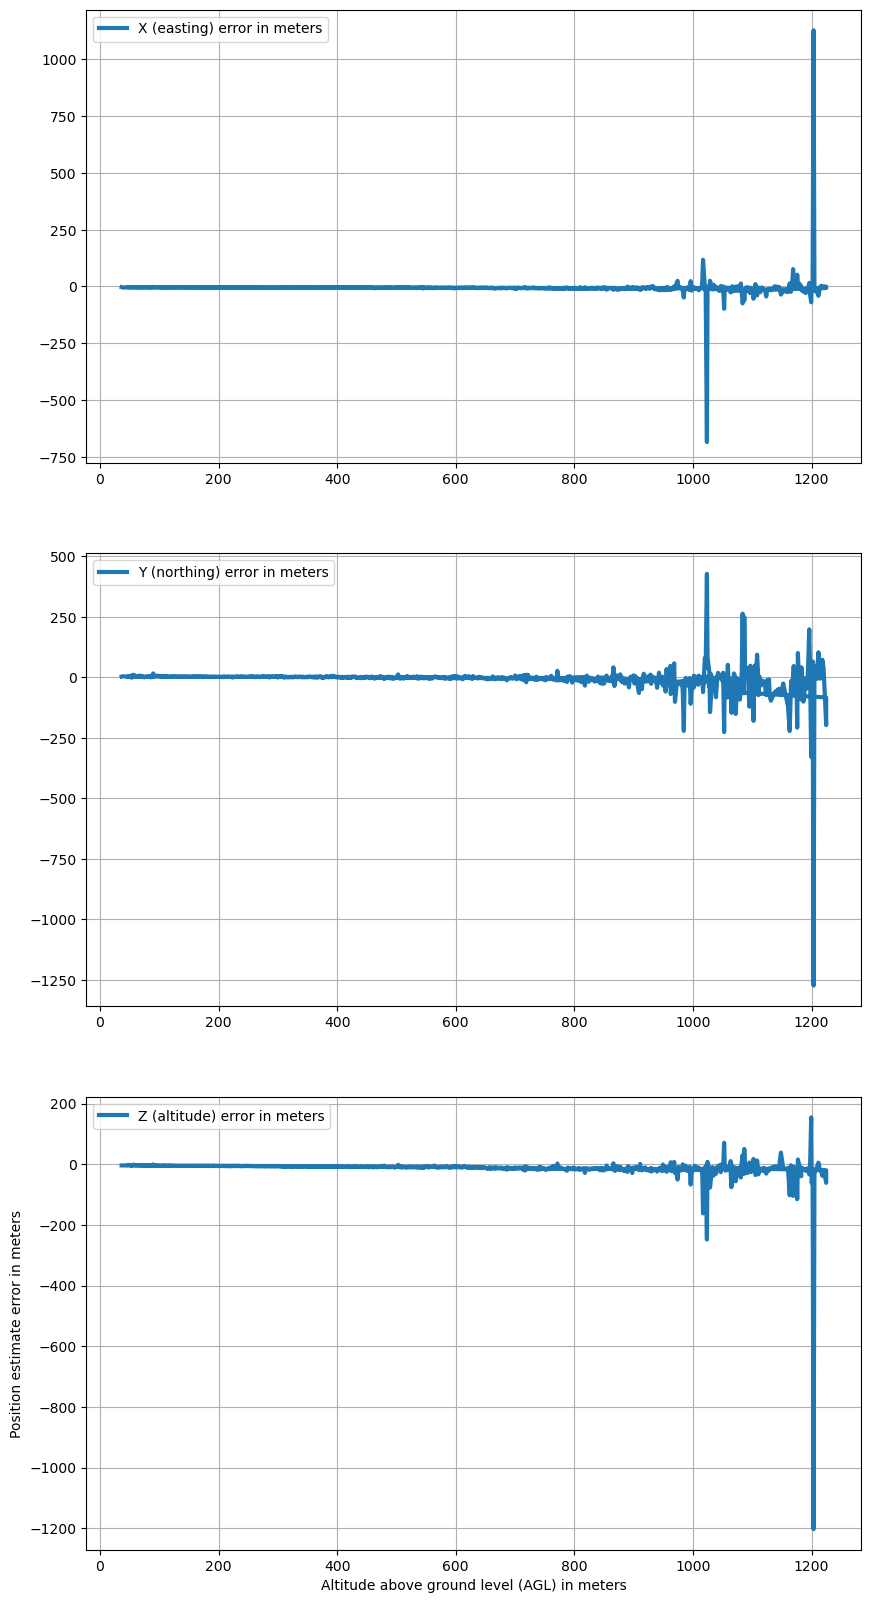

In [240]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

plt.rcParams['figure.figsize'] = (10, 20)

fig, axs = plt.subplots(3)

alt_gt = gps_position_gt[matched_indices, 3]

def draw_line(plot_idx, x, y, label):
    axs[plot_idx].plot(x, y, label=label)
    axs[plot_idx].legend(loc='best')
    axs[plot_idx].grid()

for i, tup in enumerate([
    (alt_gt, x_error, "X (easting) error in meters"),
    (alt_gt, y_error, "Y (northing) error in meters"),
    (alt_gt, z_error, "Z (altitude) error in meters")
]):
    draw_line(i, *tup)

plt.xlabel('Altitude above ground level (AGL) in meters')
plt.ylabel('Position estimate error in meters')

print(f"Minimum altitude: {np.min(alt_gt)} meters")
print(f"Maximum altitude: {np.max(alt_gt)} meters")

## Error distributions

Here we will plot the position error estimate distributions when flight altitude is below 800 meters (i.e. where the estimates should be good as discovered in earlier analysis).

### TODO

* Check whether there is systemic bias in z/altitude error (KSQL airport simulation starting altitude is a few meters AMSL which is accounted for by GISNav estimates but not by simulator ground truth data)

X (easting) error statistics
---------------------
Mean: -5.311341046482508
Mean (abs): 5.311341046482508
Median: -5.002666722516201
Median (abs): 5.002666722516201
Standard Deviation: 1.2796559261211964
Minimum: -11.844985501263572
Maximum: -1.2936908010504151

Y (northing) error statistics
---------------------
Mean: 0.38755859981702917
Mean (abs): 0.38755859981702917
Median: 1.4455340436070334
Median (abs): 1.4455340436070334
Standard Deviation: 4.157432638821996
Minimum: -21.471740337631218
Maximum: 27.16492057831399

Z (altitude) error statistics
---------------------
Mean: -8.177032867161572
Mean (abs): 8.177032867161572
Median: -7.606997436523443
Median (abs): 7.606997436523443
Standard Deviation: 3.142902928187491
Minimum: -21.254019531250037
Maximum: 2.5049956054687073



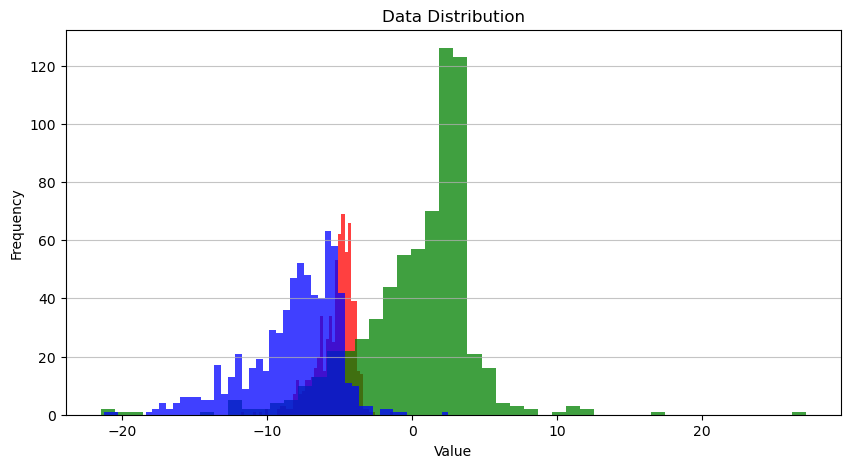

In [253]:
plt.rcParams['figure.figsize'] = (10, 5)

# cutoff at 800 meters - assume estimates above that flight altitude are not reliable
good_indices = np.where(alt_gt < 800)

def print_stats(data, title):
    # Calculate basic statistics
    mean_value = np.mean(data)
    mean_value_abs = np.abs(mean_value)
    median_value = np.median(data)
    median_value_abs = np.abs(median_value)
    std_deviation = np.std(data)
    min_value = np.min(data)
    max_value = np.max(data)

    print(title)
    print("---------------------")
    print("Mean:", mean_value)
    print("Mean (abs):", mean_value_abs)
    print("Median:", median_value)
    print("Median (abs):", median_value_abs)
    print("Standard Deviation:", std_deviation)
    print("Minimum:", min_value)
    print("Maximum:", max_value)
    print("")

def plot_hist(data, color):
    # Plotting the distribution
    plt.hist(data, bins=50, alpha=0.75, color=color)
    plt.title('Data Distribution')
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.grid(axis='y', alpha=0.75)

x_error_good = x_error[good_indices]
y_error_good = y_error[good_indices]
z_error_good = z_error[good_indices]

print_stats(x_error_good, "X (easting) error statistics")
plot_hist(x_error_good, "red")

print_stats(y_error_good, "Y (northing) error statistics")
plot_hist(y_error_good, "green")

print_stats(z_error_good, "Z (altitude) error statistics")
plot_hist(z_error_good, "blue")

## Error generally lower at lower flight altitudes?

As we get closer to ground we see better. By restricting flight altitude to below 150 meters we roughly halve the average absolute error in meters in the X and Z dimensions, but in this simulation also increase it in the Y dimension.

X (easting) error statistics
---------------------
Mean: -3.812747052795514
Mean (abs): 3.812747052795514
Median: -3.8988754881337417
Median (abs): 3.8988754881337417
Standard Deviation: 0.48906449211549274
Minimum: -5.435875109855852
Maximum: -1.2936908010504151

Y (northing) error statistics
---------------------
Mean: 3.667178627318585
Mean (abs): 3.667178627318585
Median: 3.213533380285183
Median (abs): 3.213533380285183
Standard Deviation: 2.2479741317560102
Minimum: -1.1897857149913982
Maximum: 16.623641532603095

Z (altitude) error statistics
---------------------
Mean: -4.491945866765202
Mean (abs): 4.491945866765202
Median: -4.812001342773435
Median (abs): 4.812001342773435
Standard Deviation: 0.9703219719534165
Minimum: -5.579992675781256
Maximum: -0.44999780273437295



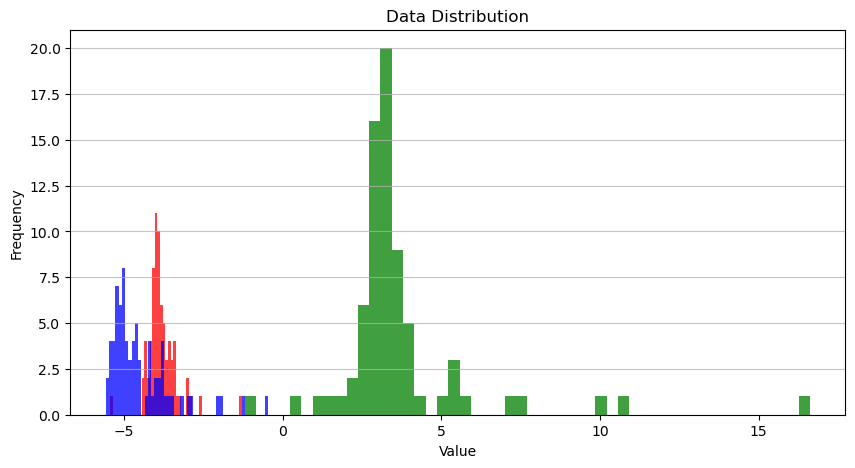

In [252]:
plt.rcParams['figure.figsize'] = (10, 5)

# cutoff at 150 meters
good_indices = np.where(alt_gt < 150)

x_error_good = x_error[good_indices]
y_error_good = y_error[good_indices]
z_error_good = z_error[good_indices]

print_stats(x_error_good, "X (easting) error statistics")
plot_hist(x_error_good, "red")

print_stats(y_error_good, "Y (northing) error statistics")
plot_hist(y_error_good, "green")

print_stats(z_error_good, "Z (altitude) error statistics")
plot_hist(z_error_good, "blue")